# Integration of CITE-seq and scRNA-seq data

Here we demonstrate how to integrate CITE-seq and scRNA-seq datasets with totalVI. The same principles here can be used to integrate CITE-seq datasets with different sets of measured proteins.

If running in Colab, navigate to Runtime -> Change runtime type and ensure you're using a Python 3 runtime with GPU hardware accelerator installation in Colab can take several minutes.



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yoseflab/scvi/blob/dataset_refactor/docs/tutorials/cite_scrna_integration_w_totalVI.ipynb)

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install --quiet git+https://github.com/yoseflab/scvi@rich_progress#egg=scvi[notebooks]

     |████████████████████████████████| 112kB 7.8MB/s 
     |████████████████████████████████| 122kB 12.6MB/s 
     |████████████████████████████████| 8.7MB 12.8MB/s 
     |████████████████████████████████| 4.3MB 66.4MB/s 
     |████████████████████████████████| 153kB 71.9MB/s 
     |████████████████████████████████| 2.2MB 55.7MB/s 
     |████████████████████████████████| 2.4MB 53.8MB/s 
     |████████████████████████████████| 3.2MB 53.7MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 7.7MB 52.5MB/s 
     |████████████████████████████████| 952kB 33.6MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 92kB 12.0MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


## Imports and data loading

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9

import scanpy as sc
import scvi

# Sets the random seed for torch and numpy
scvi.set_seed(0)
sc.set_figure_params(figsize=(4, 4))

Here we focus on two CITE-seq datasets of peripheral blood mononuclear cells from 10x Genomics and used in the totalVI manuscript. We have already filtered these datasets for doublets and low-quality cells and genes.

The quality of totalVI's protein imputation is somewhat reliant on how well the datasets mix in the latent space. In other words, it's assumed here the datasets largely share the same cell subpopulations.

In [3]:
adata = scvi.dataset.pbmcs_10x_cite_seq(run_setup_anndata=False)

INFO      Downloading file at data/pbmc_10k_protein_v3.h5ad                     
INFO      Downloading file at data/pbmc_5k_protein_v3.h5ad                      


In [4]:
# batch 0 corresponds to dataset_10k, batch 1 corresponds to dataset_5k
batch = adata.obs.batch.values.ravel()
adata.obs.batch

index
AAACCCAAGATTGTGA-1-0    0
AAACCCACATCGGTTA-1-0    0
AAACCCAGTACCGCGT-1-0    0
AAACCCAGTATCGAAA-1-0    0
AAACCCAGTCGTCATA-1-0    0
                       ..
TTTGGTTGTACGAGTG-1-1    1
TTTGTTGAGTTAACAG-1-1    1
TTTGTTGCAGCACAAG-1-1    1
TTTGTTGCAGTCTTCC-1-1    1
TTTGTTGCATTGCCGG-1-1    1
Name: batch, Length: 10849, dtype: int64

Now we hold-out the proteins of the 5k dataset. To do so, we can replace all the values with 0s. We will store the original values to validate after training.

In [5]:
held_out_proteins = adata.obsm["protein_expression"][batch == 1].copy()
adata.obsm["protein_expression"].loc[batch == 1] = np.zeros_like(adata.obsm["protein_expression"][batch == 1])

In [6]:
sc.pp.highly_variable_genes(
    adata, 
    batch_key="batch",
    flavor="seurat_v3",
    n_top_genes=4000, 
    subset=True
)

<div class="alert alert-info">

Important

scvi-tools will automatically detect proteins as missing in a certain batch if the protein has 0 counts for each cell in the batch. In other words, to indicate a protein is missing in a certain batch, please set it to 0 for each cell.

</div>

In [7]:
scvi.dataset.setup_anndata(adata, batch_key="batch", protein_expression_obsm_key="protein_expression")

INFO      Using batches from adata.obs["batch"]                                 
INFO      No label_key inputted, assuming all cells have same label             
INFO      Using data from adata.X                                               
INFO      Computing library size prior per batch                                
INFO      Using protein expression from adata.obsm['protein_expression']        
INFO      Using protein names from columns of adata.obsm['protein_expression']  
INFO      Found batches with missing protein expression                         
INFO      Successfully registered anndata object containing 10849 cells, 4000   
          genes, 2 batches, 1 labels, and 14 proteins. Also registered 0 extra  
          categorical covariates and 0 extra continuous covariates.             
INFO      Please do not further modify adata until model is trained.            


## Prepare and run model

In [8]:
vae = scvi.models.TOTALVI(adata, latent_distribution="normal")

In [9]:
vae.train()

INFO      KL warmup for 400 epochs                                              


Output()

INFO      Reducing LR on epoch 382.                                             
INFO      Training time:  514 s. / 400 epochs                                   


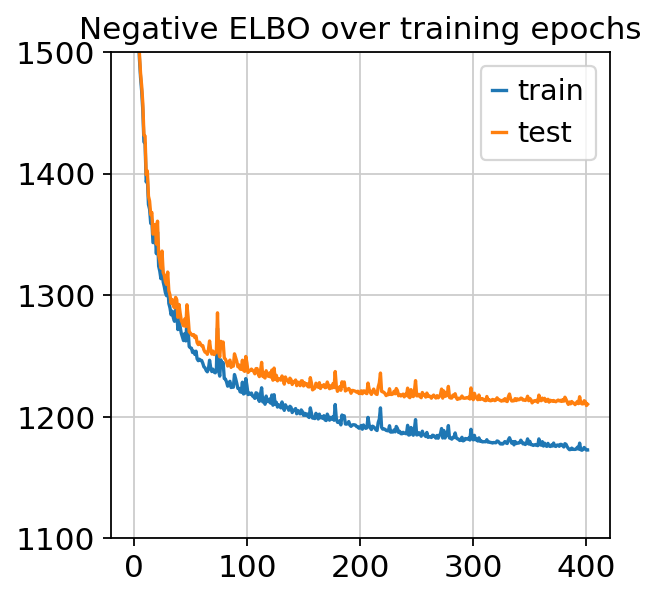

In [10]:
plt.plot(vae.trainer.history["elbo_train_set"], label="train")
plt.plot(vae.trainer.history["elbo_test_set"], label="test")
plt.title("Negative ELBO over training epochs")
plt.ylim(1100, 1500)
plt.legend()

## Analyze outputs

Again, we rely on Scanpy.

In [11]:
adata.obsm["X_totalVI"] = vae.get_latent_representation()
adata.obsm["protein_fg_prob"] = vae.get_protein_foreground_probability(transform_batch=0)

rna, protein = vae.get_normalized_expression(transform_batch=0, n_samples=25, return_mean=True)

<div class="alert alert-info">

Note

`transform_batch` is a power parameter. Setting this allows one to predict the expression of cells as if they came from the inputted batch. In this case, we've observed protein expression in batch 0 (batch categories from original adata object), but we have no protein expression in batch 1. We'd like to take the cells of batch 1 and make a counterfactual prediction: "What would the expression look like if my batch 1 cells came from batch 0?"

</div>

In [12]:
protein.iloc[:5, :5]

CD3_TotalSeqB  ...  CD15_TotalSeqB
index                                ...                
AAACCCAAGATTGTGA-1-0       8.992323  ...        0.000000
AAACCCACATCGGTTA-1-0      21.143919  ...        0.000000
AAACCCAGTACCGCGT-1-0       5.382979  ...        0.000000
AAACCCAGTATCGAAA-1-0       0.000000  ...       75.900261
AAACCCAGTCGTCATA-1-0       0.000000  ...        0.000000

[5 rows x 5 columns]

<div class="alert alert-info">

Note

The following is for illustrative purposes. In the code blocks above, we have the denoised protein values for each cell. These values have the expected protein background component removed. However, to compare to the held out protein values, we must include both protein foreground and background. We recommend using the values above for downstream tasks.

</div>

In [13]:
_, protein_means = vae.get_normalized_expression(
    n_samples=25, 
    transform_batch=0,
    include_protein_background=True,
    sample_protein_mixing=False,
    return_mean=True,
)

In [14]:
sc.pp.neighbors(adata, use_rep="X_totalVI")
sc.tl.umap(adata, min_dist=0.4)
sc.tl.leiden(adata, key_added="leiden_totalVI")

In [15]:
d_names = ["PBMC 10k", "PBMC 5k"]
adata.obs["dataset"] = pd.Categorical(d_names[b] for b in adata.obs.batch.astype(int).ravel())

Trying to set attribute `.uns` of view, copying.


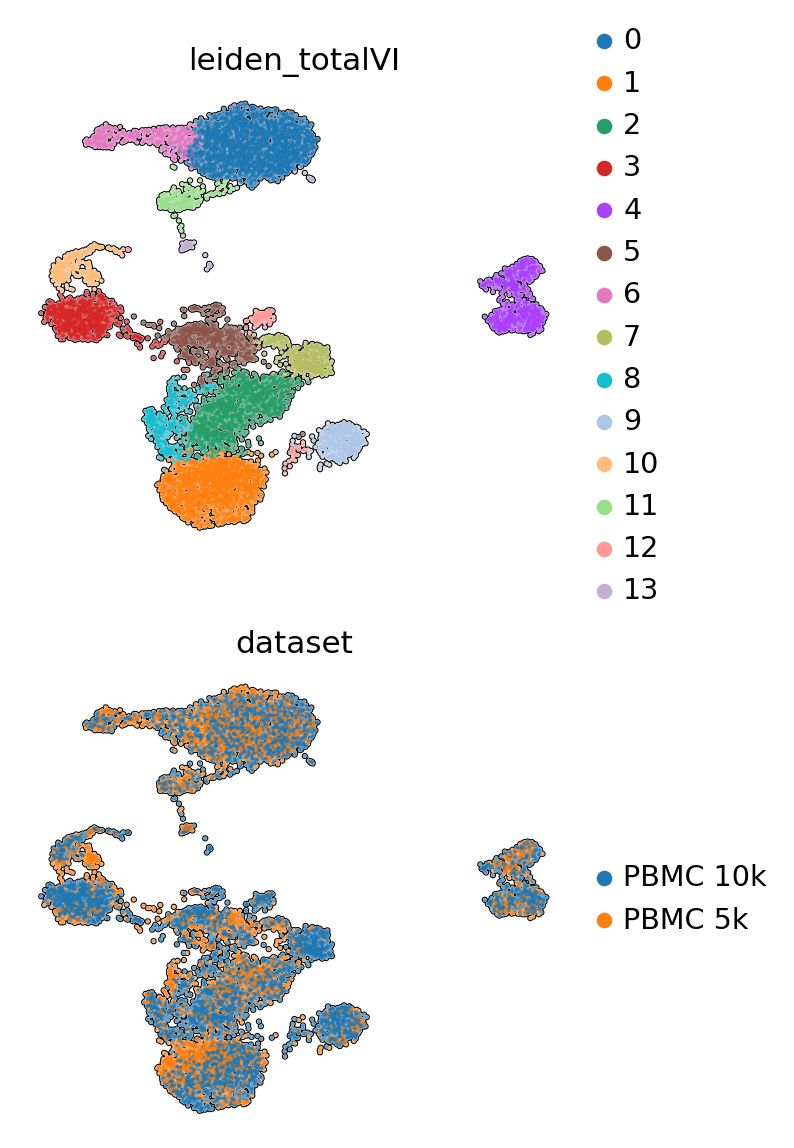

In [16]:
perm_inds = np.random.permutation(len(adata))
sc.pl.umap(
    adata[perm_inds], 
    color=["leiden_totalVI", "dataset"],
    ncols=1,
    frameon=False,
    add_outline=True,
)

In [17]:
batch = adata.obs.batch.astype(int).values.ravel()
combined_protein = np.concatenate([adata.obsm["protein_expression"].values[batch==0], held_out_proteins], axis=0)

# cleaner protein names
parsed_protein_names = [p.split("_")[0] for p in adata.obsm["protein_expression"].columns]
for i, p in enumerate(parsed_protein_names):
    adata.obs["{} imputed".format(p)] = protein_means.iloc[:, i]
    adata.obs["{} observed".format(p)] = combined_protein[:, i]

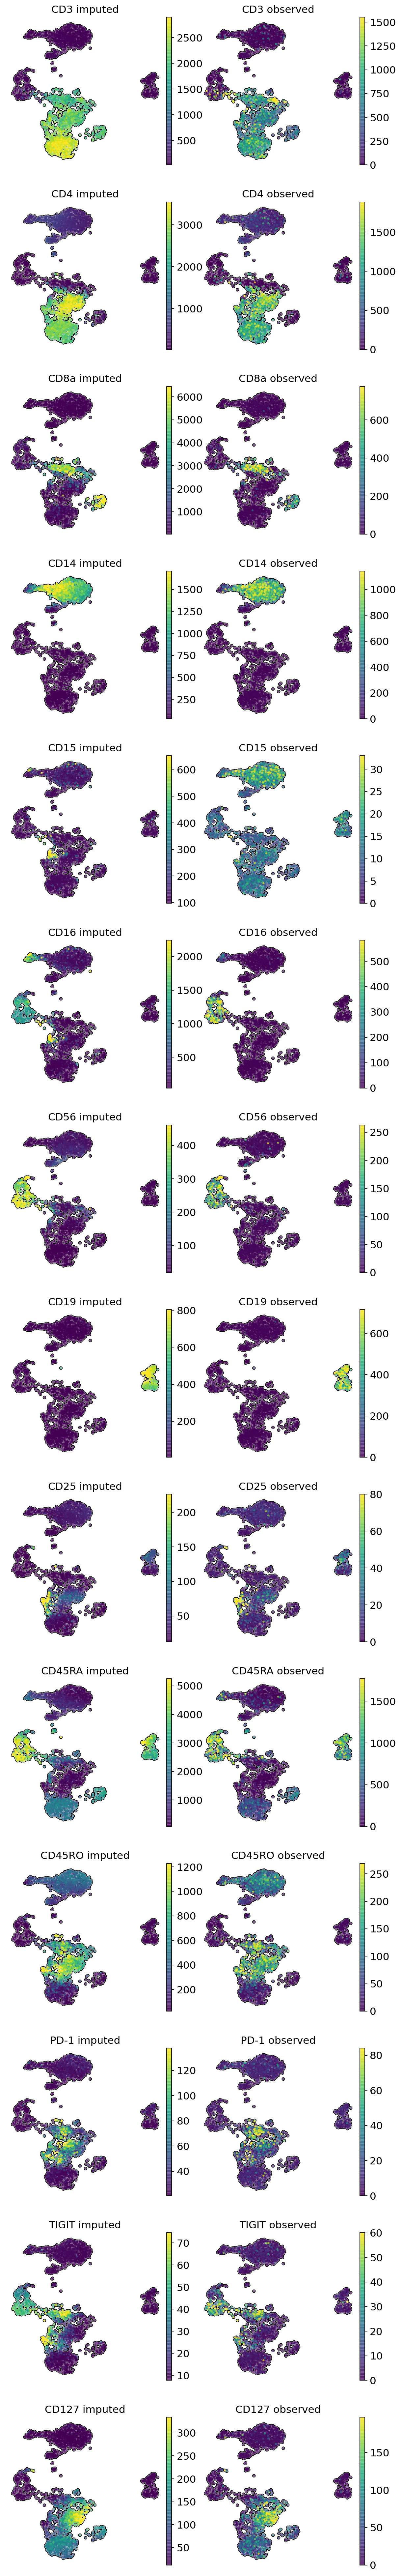

In [18]:
viz_keys = []
for p in parsed_protein_names:
    viz_keys.append(p + " imputed")
    viz_keys.append(p + " observed")

sc.pl.umap(
    adata[adata.obs.dataset == "PBMC 5k"],
    color=viz_keys,
    ncols=2,
    vmax="p99",
    frameon=False,
    add_outline=True,
    wspace=0.1
)

## Imputed vs denoised correlations

In [19]:
from scipy.stats import pearsonr
imputed_pros = protein_means[batch == 1]
held_vs_denoised = pd.DataFrame()
held_vs_denoised["Observed (log)"] = np.log1p(held_out_proteins.values.ravel())
held_vs_denoised["Imputed (log)"] = np.log1p(imputed_pros.to_numpy().ravel())
protein_names_corrs = []
for i, p in enumerate(parsed_protein_names):
    protein_names_corrs.append(parsed_protein_names[i] + ": Corr=" + str(np.round(pearsonr(held_out_proteins.values[:, i], imputed_pros.iloc[:, i])[0], 3)))
held_vs_denoised["Protein"] = protein_names_corrs * len(held_out_proteins)
held_vs_denoised.head()

Observed (log)  Imputed (log)           Protein
0        3.258097       3.585824   CD3: Corr=0.773
1        5.105945       6.074321   CD4: Corr=0.866
2        2.833213       3.449803  CD8a: Corr=0.806
3        6.546785       7.302605  CD14: Corr=0.911
4        2.995732       4.746261  CD15: Corr=0.018

We notice that CD15 has a really low correlation (imputation accuracy). Recall that imputation involves a counterfactual query -- "what would the protein expression have been for these cells if they came from the PBMC10k dataset?" Thus, any technical issues with proteins in CD15 in PBMC10k will be reflected in the imputed values. It's the case here that CD15 was not captured as well in the PBMC10k dataset compared to the PBMC5k dataset.

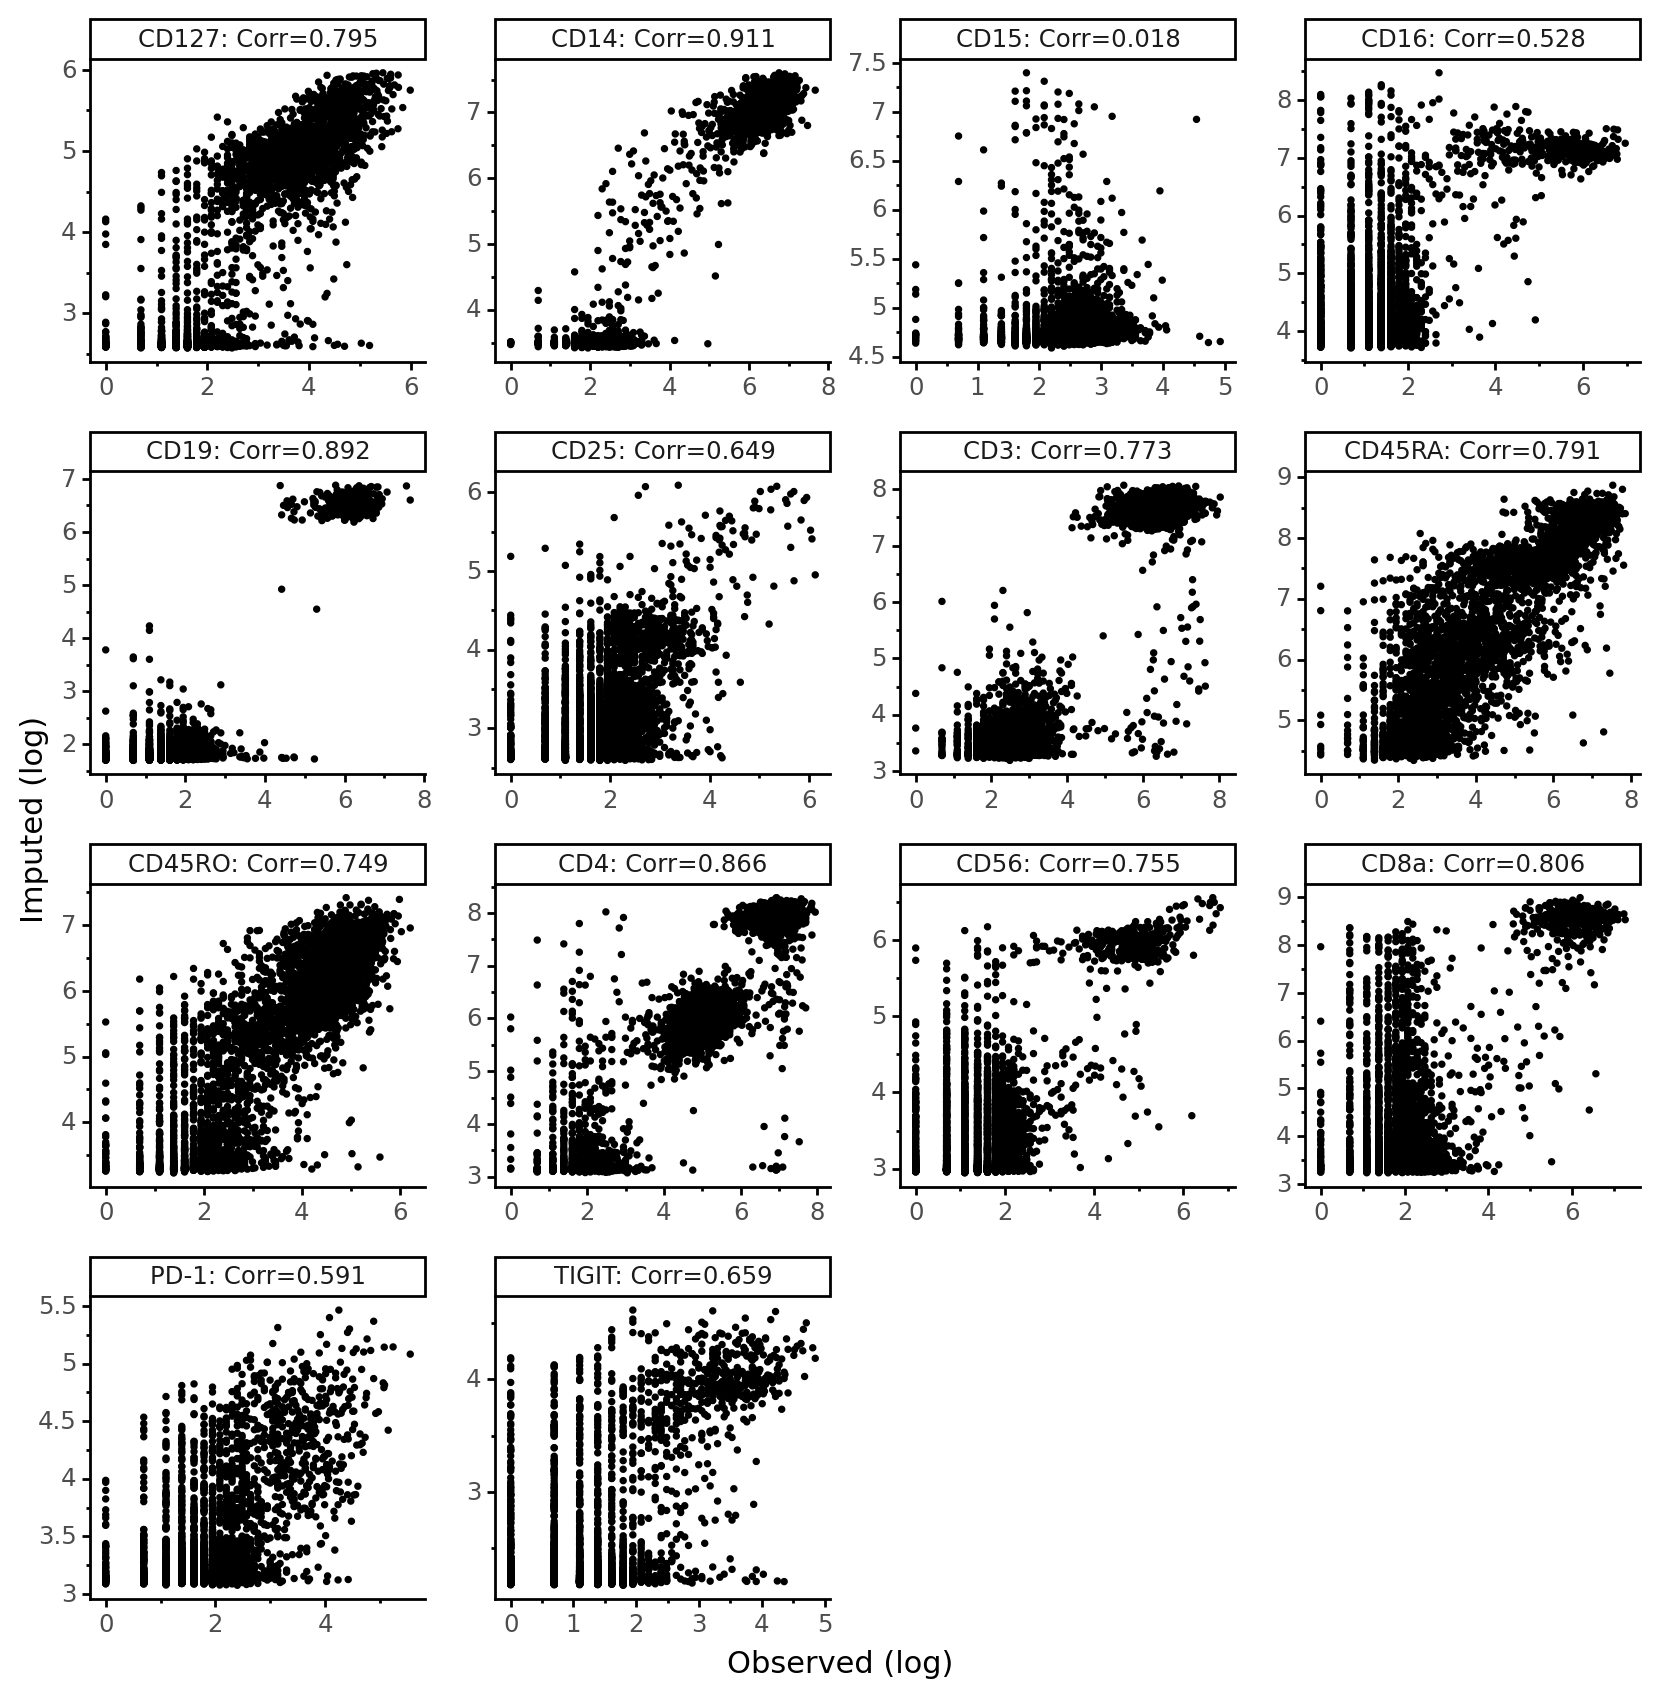

<ggplot: (-9223363274290623046)>

In [20]:
p9.theme_set(p9.theme_classic)
(p9.ggplot(held_vs_denoised, p9.aes("Observed (log)", "Imputed (log)"))
 + p9.geom_point(size=0.5)
 + p9.facet_wrap("~Protein", scales="free")
 + p9.theme(figure_size=(10, 10), panel_spacing=.35,)
)
